In [1]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

from main_meg_qc import initial_stuff


In [2]:
duration=1 #in minutes
n_events, df_epochs_mags, df_epochs_grads, epochs_mags, epochs_grads, mags, grads, filtered_d, filtered_d_resamp, raw_cropped, raw=initial_stuff(duration)


Opening raw data file ../data/sub_HT05ND16/210811/mikado-1.fif/...


/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:8: RuntimeWarning: This filename (../data/sub_HT05ND16/210811/mikado-1.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file)


    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/../data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 

/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:65: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)


Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
42 events found
Event IDs: [    9    19    20    21    22    23    27    31 16393 16402 16403 16405
 16411 32741 32749 32750 32759]
Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
5 events found
Event IDs: [ 9 19 20 21]
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
8 projection items activated
Loading data for 5 events and 1201 original time points ...
0 bad epochs dropped


/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:65: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)
/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:80: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)


In [3]:
#Find ECG events by localizing the R wave peaks.
#IT DOES FIND ECG EVENTS, even when no dedicated channels is present. Reconstructs from magnetometers.

ecg_events, ch_ecg, average_pulse, ecg=mne.preprocessing.find_ecg_events(raw_cropped, return_ecg=True, verbose=False)
# ecg_events array
# The events corresponding to the peaks of the R waves.
# ch_ecg - str - Name of channel used.

# average_pulse float
# The estimated average pulse. If no ECG events could be found, this will be zero.

# ecg array | None
# The ECG data of the synthesized ECG channel, if any. This will only be returned if return_ecg=True was passed.

# HOW TO FIND THE TIME OF EVENTS:
# https://github.com/mne-tools/mne-python/issues/5201
ecg_events_times  = (ecg_events[:, 0] - raw.first_samp) / raw.info['sfreq']

#https://mne.tools/stable/glossary.html#term-first_samp
#The first_samp attribute of Raw objects is an integer representing the number of time samples that passed between 
# the onset of the hardware acquisition system and the time when data recording started. This approach to sample 
# numbering is a peculiarity of VectorView MEG systems, but for consistency it is present in all Raw objects regardless 
# of the source of the data. In other words, first_samp will be 0 in Raw objects loaded from non-VectorView data files.


#print('ECG events: \n', ecg_events) 
print('Channels used to detect ECG: ', ch_ecg) 
print('Average pulse: ', average_pulse) 
print('ECG data of the synthesized ECG channel: \n',ecg)

print('Times of ECG events: \n', ecg_events_times)

Channels used to detect ECG:  None
Average pulse:  58.99901668305529
ECG data of the synthesized ECG channel: 
 [[ 6.31088724e-29 -8.30342161e-15 -1.64941887e-14 ...  2.73842249e-14
   1.38617319e-14 -6.31088724e-29]]
Times of ECG events: 
 [ 0.358  1.287  2.216  3.161  4.084  5.014  5.976  6.967  7.938  8.906
  9.855 10.885 11.981 13.054 14.093 15.179 16.241 17.237 18.238 19.194
 20.184 21.201 22.128 23.076 24.044 25.017 25.932 26.857 27.839 28.867
 29.814 30.761 31.718 32.696 33.623 34.538 35.462 36.42  37.402 38.34
 39.286 40.239 41.169 42.093 43.035 43.978 44.89  45.775 46.69  47.63
 49.689 50.715 51.7   52.762 53.74  56.451 57.456 58.516 59.49 ]


In [5]:
len(ecg_events)

59

In [20]:
#Plot the found ECG events on one of the channels:

selected_mags = [item[1] for item in mags]
selected_grads = [item[1] for item in grads]
data_mags, _ = filtered_d[selected_mags, :]  
data_grads, _ = filtered_d[selected_grads, :]  

dt=duration/len(data_mags[30]) #samplig frequency (resampled data)

#ecg_events_times_ind=np.array(ecg_events_times*raw.info['sfreq']/1000).astype(int)

#t=np.arange(0, duration, dt) 
t=np.arange(0, 60, 1/raw.info['sfreq'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=data_mags[2], name='data'));
#fig.add_vline(x=ecg_events_times, line_width=1, line_dash="dash", line_color="green")
for ecg in ecg_events_times:
    fig.add_vline(x=ecg, line_width=1, line_color="green")

fig.update_layout(
    title={
    'text': "ECG events on data of 1 magnetometer",
    'y':0.85,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Time in sec",
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'e'))

fig.show()

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 313 (average pulse 62 / min.)
Not setting metadata
Not setting metadata
313 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
Loading data for 313 events and 1001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not 

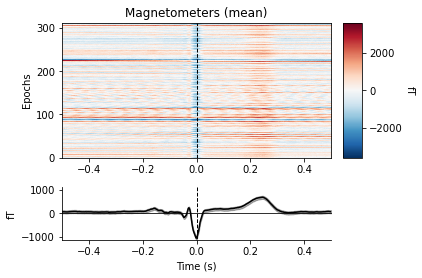

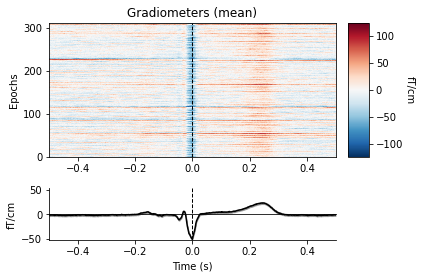

[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

In [6]:
#THIS FUNCTION CREATES EPOCHS ON BASE OF ECG EVENTS. 
# It calls find_ecg_events internally, so no need to run previous cell for it.

%matplotlib inline

ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_cropped)
ecg_epochs.plot_image(combine='mean')

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 8)
8 projection items activated
SSP projectors applied...


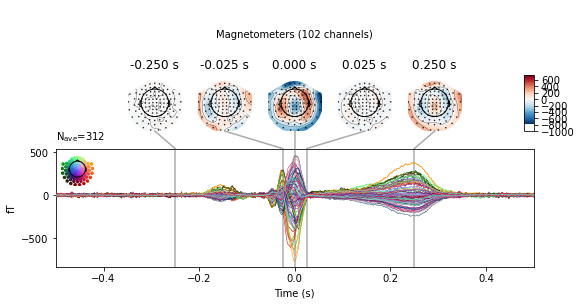

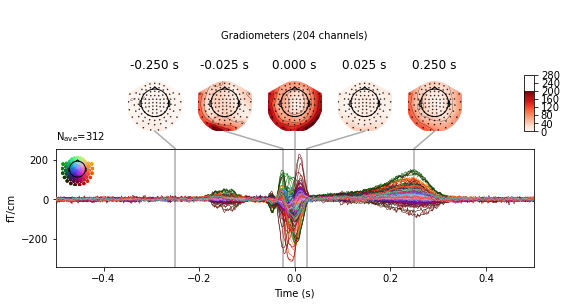

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [7]:
# Here I simply repeat the steps from mne tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#averaging the ECG epochs together:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])
# I guess 0 represents the actual ECG event and all around - the epoch and how the ECG signal developes during 
# the ECG epoch on everage over all channels?


In [13]:
# Find EOG events:
# https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html

eog_events=mne.preprocessing.find_eog_events(raw, thresh=None, ch_name=None)
# threshfloat | None
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying 
# peak-finding algorithm. Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# UNLIKE ECG, CAN NOT RECONSTRUCT EOG EVENTS IF NO DEDICATED CHANNEL IS PRESENT. SO EPOCHS CANT BE CREATED EITHER
# AS EOG channels it needs either: with type eog or ordinary EEG channel that was placed close to the eyes, like Fp1 or Fp2

# But we dont have any of these

# Another related function, but again needs EOG channel or other channels where EOG should be extracted from:
# https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.find_bads_eog


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_32672/58517370.py:2: DeprecationWarning: No EOG channel found. Trying with EEG 061 and EEG 062. This functionality will be removed in version 0.24
  eog_events=mne.preprocessing.find_eog_events(raw, thresh=None, ch_name=None)


ValueError: Could not find any EOG channels.

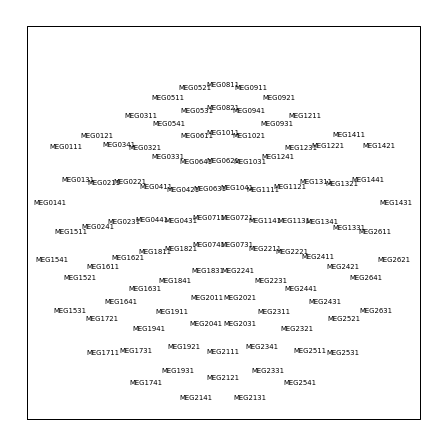

Using EOG channels: MEG0521, MEG0911, MEG0511, MEG0921
EOG channel index for this subject is: [ 59  62 101 104]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 17 significant peaks
Number of EOG events detected: 17


In [37]:

# "If you don’t have an EOG channel, find_bads_eog has a ch_name parameter that you can use as a proxy for EOG. 
# You can use a single channel, or create a bipolar reference from frontal EEG sensors and use that as virtual EOG channel. 
# This carries a risk however: you must hope that the frontal EEG channels only reflect EOG and not brain dynamics in 
# the prefrontal cortex (or you must not care about those prefrontal signals)."

# So here I plot the magnetometers layout, choose 4 magnetometers near the eyes and try to extract eyeblinks from there

# What is better mags or grads for eyeblinks reconstruction? Or both?

%matplotlib inline

layout_from_raw=mne.channels.find_layout(raw.info, ch_type='mag')
fig=layout_from_raw.plot()

eog_events=mne.preprocessing.find_eog_events(raw, thresh=1e-8, ch_name=['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921'])
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying peak-finding algorithm. 
# Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# Detected only 3 EOG events in th entire 1h dataset if threshold is set to defailt: thresh=None
# -> Try to adjust threshold or, maybe it just doesnt really work.
# -> Above: set the threshold to 1e-8, detects 17 eyeblink events - also too little. But I got no idea what threshold value is optimal.



Using EOG channels: MEG0521, MEG0911, MEG0511, MEG0921
EOG channel index for this subject is: [ 59  62 101 104]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected: 3
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 8)
Loading data for 3 events and 1001 original tim

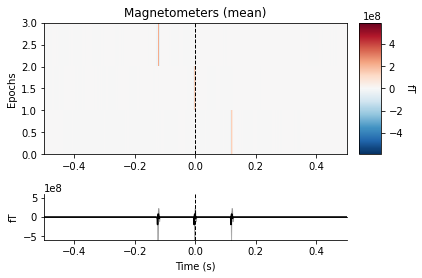

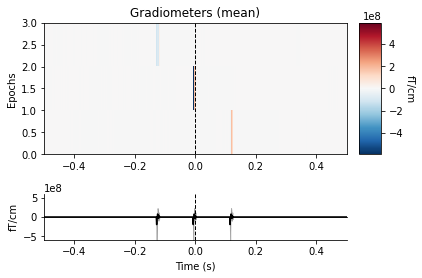

Created an SSP operator (subspace dimension = 8)
8 projection items activated
SSP projectors applied...


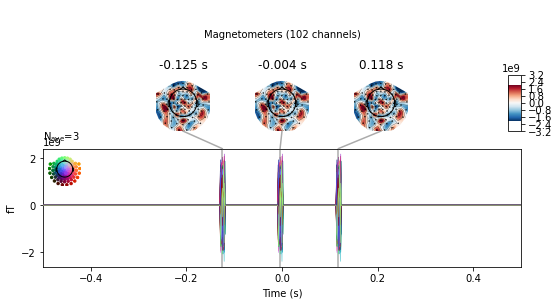

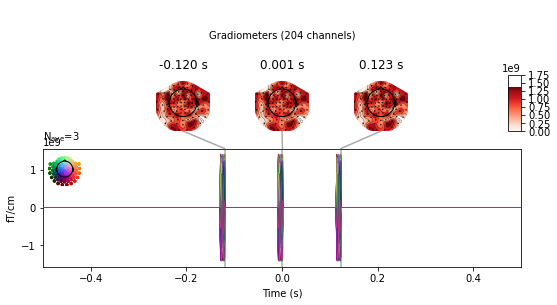

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [38]:
# So lets imagine the eyblink are detected correctly. Extract EOG epochs:

eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name=['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921'], baseline=(-0.5, -0.2))
#This function will internally call the find_eog_events again (no need to run previous cell). So I pass the chosen mag channels near the eyes again.


eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

#Looks definitely not the same as in preprocessing tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#Should discuss what do we see here.

# Also - wan to plot data of these 4 channels but I again cant find hot to plot patticukar channels.


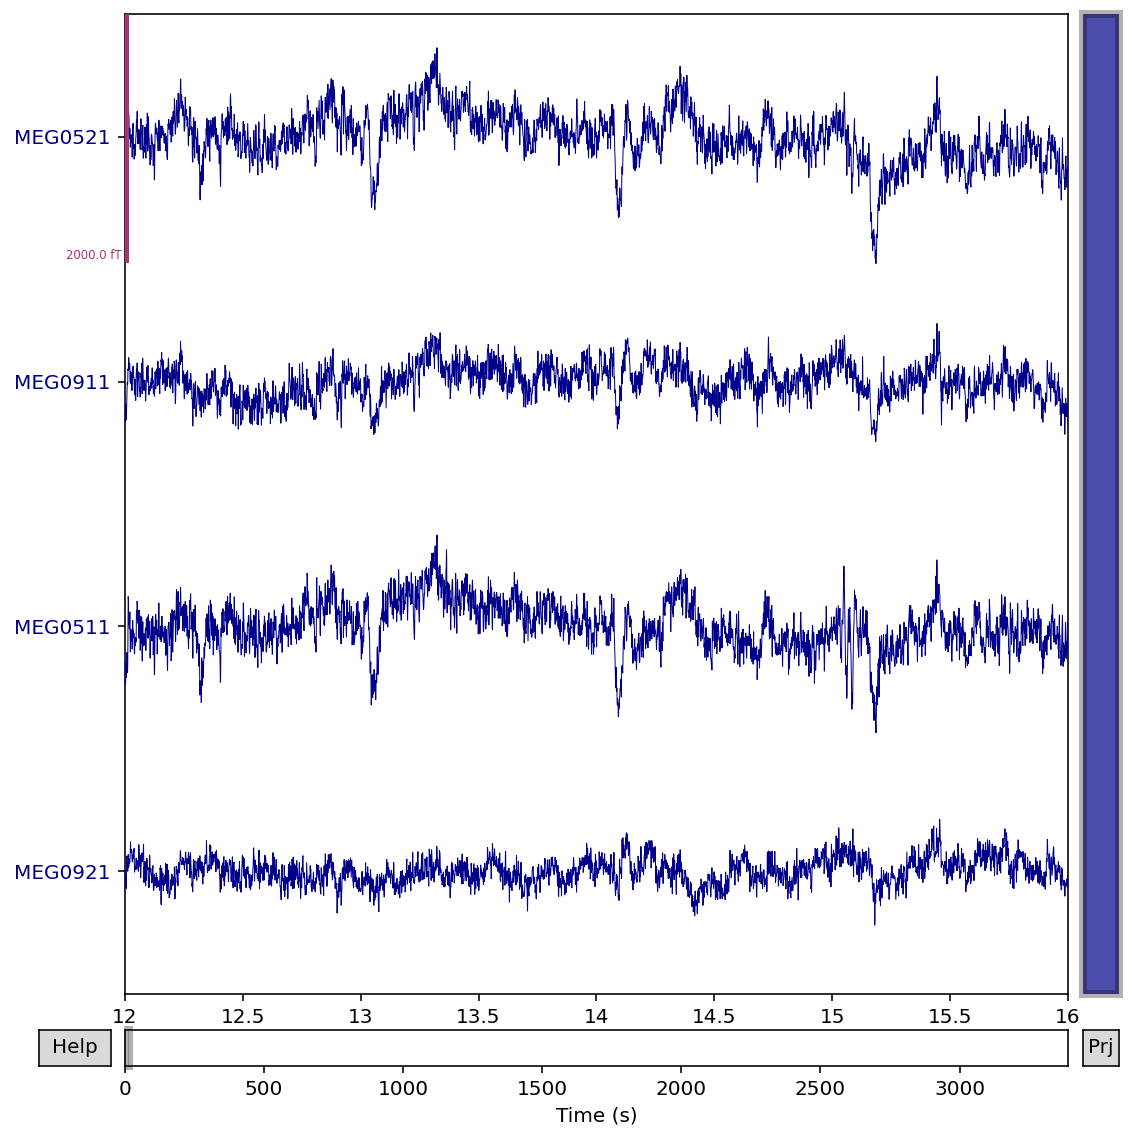

In [70]:
#%% Now want to see the data for these 4 channels I chose for eyeblinks:
chans = ['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921']

#I only know how to plot channels by the idexes, not by names, so have to extract indexes first:
EOG_ch=[]
for c in chans:
    ch=[item for item in mags if c in item]
    EOG_ch.append(ch[0][1])

%matplotlib qt
raw.plot(order=EOG_ch, start=12, duration=4) #plot here only a part of channel."

#Lets discuss if these look like eyeblink!

In [51]:
# Next, there is ICA used for ECG and EOG artifacts repair.
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

# Functions ica_find_ecg_events and ica_find_eog_events - are not working independently, 
# they need to functions above to run first





In [ ]:
# found interesting function to fix stimulus artifacts: 
# https://mne.tools/stable/generated/mne.preprocessing.fix_stim_artifact.html